In [1]:
import pd as pd
from matplotlib import pyplot as plt
import os
import glob
from zipfile import ZipFile
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
import torchvision.datasets as dataset
import torchvision.transforms as transforms
from PIL import Image
from tqdm import tqdm
import pickle
# from modularTraining.test_all_models import get_dataloaders


%load_ext autoreload
%autoreload 2

In [2]:
IMAGE_SIZE= 224
exp_name= "sex_eyeglass"

transform = transforms.Compose(
            [transforms.Resize(IMAGE_SIZE),
             transforms.ToTensor(),
             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
             ]
        )

In [3]:


# data_path = sorted(glob.glob('/local/scratch/a/rahman89/Datasets/CelebAMask-HQ/CelebAMask-HQ/CelebA-HQ-img/*.jpg')) # This was a bug. It did not sort the images as 0,1,2,...
data_path = '/local/scratch/a/rahman89/Datasets/CelebAMask-HQ/CelebAMask-HQ/CelebA-HQ-img/'
label_path = "/local/scratch/a/rahman89/Datasets/CelebAMask-HQ/CelebAMask-HQ/CelebAMask-HQ-attribute-anno.txt"
sep=" "
rowst=2
colst=2

label_list = open(label_path).readlines()[rowst:]


data_label = []
for i in range(len(label_list)):
    each_row= label_list[i].split(sep)
    data_label.append(each_row)



image_names=[]
for m in range(len(data_label)):
    image_names.append(data_label[m][0])  #image id
    data_label[m] = data_label[m][colst:]  # rest of the labels
    data_label[m] = [int(p) for p in data_label[m]]

attributes = open(label_path).readlines()[1].split(' ')
attributes[-1]= attributes[-1].strip('\n')




In [9]:
import numpy as np
import pandas as pd
labels= np.array(data_label)

data_dict={}
for iter, att in enumerate(attributes):
    data_dict[att] = labels[:,iter]

data_dict['image_id']= image_names
df = pd.DataFrame(data_dict)
df = df.replace([-1], 0)
cur_attrs=['Attractive', 'Bald',  'Eyeglasses',  'Male', 'Mustache', 'Pale_Skin',  'Wearing_Lipstick', 'Young']
all_labels= ['image_id']+ cur_attrs
df = df[all_labels]
df

,image_id,Attractive,Bald,Eyeglasses,Male,Mustache,Pale_Skin,Wearing_Lipstick,Young
0,0.jpg,1,0,0,0,0,0,1,1
1,1.jpg,1,0,0,0,0,0,1,1
2,2.jpg,1,0,0,0,0,0,1,1
3,3.jpg,1,0,0,0,0,0,1,1
4,4.jpg,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...
29995,29995.jpg,0,0,1,1,1,0,0,0
29996,29996.jpg,0,0,0,1,0,0,0,1
29997,29997.jpg,0,0,0,0,0,0,0,1
29998,29998.jpg,1,0,0,0,0,0,1,1


# Generating dataset of 10k samples


In [5]:
# Train sample size. sampled as [0:n].
Tm0e0= 3200
Tm0e1=100
Tm1e0=1000
Tm1e1= 1080

m0e0= 400
m0e1=180
m1e0=600
m1e1= 100

# Test data 2
# df_m0e0= df.loc[(df['Male'] == 0) & (df['Eyeglasses']==0)][Tm0e0: Tm0e0 + m0e0]
# df_m0e1= df.loc[(df['Male'] == 0) & (df['Eyeglasses']==1)][Tm0e1: Tm0e1 + m0e1]
# df_m1e0= df.loc[(df['Male'] == 1) & (df['Eyeglasses']==0)][Tm1e0: Tm1e0 + m1e0]
# df_m1e1= df.loc[(df['Male'] == 1) & (df['Eyeglasses']==1)][Tm1e1: Tm1e1 + m1e1]

# Test data 1
df_m0e0= df.loc[(df['Male'] == 0) & (df['Eyeglasses']==0)].tail(m0e0)
df_m0e1= df.loc[(df['Male'] == 0) & (df['Eyeglasses']==1)].tail(m0e1)
df_m1e0= df.loc[(df['Male'] == 1) & (df['Eyeglasses']==0)].tail(m1e0)
df_m1e1= df.loc[(df['Male'] == 1) & (df['Eyeglasses']==1)].tail(m1e1)


selected_df=  pd.concat([df_m0e0,df_m0e1, df_m1e0, df_m1e1])
test_df = selected_df.sample(frac=1).reset_index(drop=True)
test_df



,image_id,Attractive,Bald,Eyeglasses,Male,Mustache,Pale_Skin,Wearing_Lipstick,Young
0,29734.jpg,1,0,0,0,0,0,1,1
1,29364.jpg,0,1,0,1,1,0,0,0
2,29087.jpg,1,0,0,1,0,0,0,1
3,17724.jpg,1,0,1,0,0,0,1,1
4,28692.jpg,0,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...
1275,28615.jpg,0,1,0,1,1,0,0,1
1276,29906.jpg,1,0,0,0,0,0,1,1
1277,29745.jpg,0,0,0,1,0,0,0,0
1278,29720.jpg,1,0,0,0,0,0,0,1


In [6]:
len(df_m0e0), len(df_m0e1), len(df_m1e0), len(df_m1e1),

(400, 180, 600, 100)

In [8]:
for lb in cur_attrs:
    print(lb, len(test_df[test_df[lb]==1]))

hello


In [16]:
domain_name='test'
file_name= f'/local/scratch/a/rahman89/PycharmProjects/modularCelebA/{exp_name}/base_celeba_{domain_name}.csv'
test_df.to_csv(file_name, encoding='utf-8', index=False)
print('saved at :',file_name)

saved at : /local/scratch/a/rahman89/PycharmProjects/modularCelebA/sex_eyeglass/base_celeba_test.csv


In [17]:



def save_labels(dom_name, true_data):
	save_folder= f'/local/scratch/a/rahman89/PycharmProjects/modularCelebA/{exp_name}'
	save_loc =f'{save_folder}/8_attribute_celeba_{dom_name}.pkl'
	print('Going to save at', save_loc)
	with open(save_loc, 'wb') as f:
		pickle.dump(true_data, f)



def save_images(dom_name, true_data):
	save_folder= f'/local/scratch/a/rahman89/PycharmProjects/modularCelebA/{exp_name}'
	save_loc =f'{save_folder}/images_celeba_{dom_name}.pkl'
	print('Going to save at', save_loc)
	with open(save_loc, 'wb') as f:
		pickle.dump(true_data, f)

# saving training data and validation data as pkl file here.


save_folder= f'/local/scratch/a/rahman89/PycharmProjects/modularCelebA/{exp_name}'
os.makedirs(save_folder, exist_ok=True)

label_path= f"/local/scratch/a/rahman89/PycharmProjects/modularCelebA/{exp_name}/base_celeba_test.csv"

sampled_labels = pd.read_csv(label_path)

true_dataset = {}
for lb in cur_attrs:
    true_dataset[lb]= torch.tensor(sampled_labels[lb].values)


save_labels('test_domain', true_dataset)

img_folder= '/local/scratch/a/rahman89/Datasets/CelebAMask-HQ/CelebAMask-HQ/CelebA-HQ-img/'
images =[]
for id in tqdm(sampled_labels['image_id']):
    img_path = f'{img_folder}/{id}'
    cur_im = Image.open(img_path)
    image_tensor = transform(cur_im)
    images.append(image_tensor.unsqueeze(0))

true_dataset['I'] = torch.cat(images)

save_images(dom_name= "test_domain", true_data= true_dataset)


  


Going to save at /local/scratch/a/rahman89/PycharmProjects/modularCelebA/sex_eyeglass/8_attribute_celeba_test_domain.pkl


100%|██████████| 1242/1242 [00:09<00:00, 137.06it/s]


Going to save at /local/scratch/a/rahman89/PycharmProjects/modularCelebA/sex_eyeglass/images_celeba_test_domain.pkl


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(1)


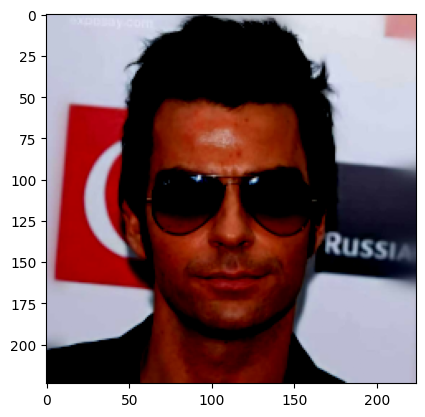

In [10]:

for iter, img in enumerate(true_dataset['I']):

    print(true_dataset['Eyeglasses'][iter])

    plt.imshow(img.cpu().permute(1,2,0))
    break



In [13]:
xx= df.loc[(df['Eyeglasses']==1)]
len(xx)

1468

In [15]:
yy = df.index[df['Eyeglasses'] == True].tolist()
len(yy)

1468